## Bruno Borguesan - Talking Detector.

OBJETIVO:
    - Utilizar visão computacional para identificar no video 'people-talking.mp4' pessoas falando, gerando como saída um resultado similar ao vídeo 'people-talking-processed.avi'.

PROCESSO REALIZADO:
    - Utilizei as bibliotecas openCV[0] e DLIB[1] para detecção de face e seus pontos, de modo a identificar quando os pontos referentes a boca estão afastados. (distancia euclidiana);
    - Testei diferentes maneiras de analisar quando a boca se mexe combinando os pontos referente a BOCA no DLIB, usando o EAR[2]; (O melhor modelo em testes empíricos foi 'compute_mouth_open_3pontos' utilizando 4 pontos da boca. (esquerda, centro, direita e horizontal);
    - o DLIB utiliza um modelo já treinados como entrada do preditor utilizando 68 pontos da face 'shape_predictor_68_face_landmarks.dat'. Alterai alguns parâmetros para geração desse modelo, utilizando como exemplo um modelo desenvolvido para os olhos[3], e executei o treinamento novamente sobre a base do IBUG[4] (+5.000 fotos com os pontos definidos - 1.7 GB), focando apenas nos 20 marcadores da boca (48~68).  
    - Parâmetros utilizados na Regressão em Cascata do DLIB: 
        Training with tree depth: 4
        Training with 500 trees per cascade level.
        Training with nu: 0.1033
        Training with random seed:
        Training with oversampling amount: 29
        Training with oversampling translation jitter: 0
        Training with landmark_relative_padding_mode: 1
        Training with feature pool size: 677
        Training with feature pool region padding: 0.0975
        Training with 12 threads.
        Training with lambda_param: 0.0251
        Training with 295 split tests.
        Fitting trees...
    - erro
        [INFO] evaluating shape predictor...
        [INFO] error: 6.969941169617737


PROBLEMAS A SEREM RESOLVIDOS:
    - Muitos erros onde não identifica a boca do personagem;
    - Otimizar a função MAR que calcula o ratio da boca;
    - Estrutura de pontos DLIB limita bastante o sistema para novos casos.
SOLUÇÕES POSSÍVEIS:
    - Aplicar algum algoritmo de otimização para definir os melhores parâmetros para geração;
    - Aplicar luminosidade parecida com o vídeo alvo nos dados de treino do DLIB focando na boca;
    - Se não tiver melhora significativa no processo de otimização dos parâmetros do DLIB, parar de usar a estrutura de pontos do DLIB e tentar desenvolver um mouth recognition próprio, combinando os dataset de face recognition disponíveis;
    - Aplicar alguma abordagem que utilize a média de frames.

OBS:
    Para optimizar o modelo para o mundo de hoje, no caso das máscaras, poderíamos aplicar o reconhecimento da face utilizando o movimento da mandíbula, já identificado no DLIB, e combinar com o áudio para identificar qual pessoa está falando.

REFERENCIAS:
    [0] https://opencv.org/
    [1] http://dlib.net/
    [2] http://vision.fe.uni-lj.si/cvww2016/proceedings/papers/05.pdf    
    [3] https://www.pyimagesearch.com/2019/12/16/training-a-custom-dlib-shape-predictor/
    [4] https://ibug.doc.ic.ac.uk/resources/300-W_IMAVIS/

In [46]:
import cv2 #openCV para analise de imagem
import dlib #dlib para detecção de face
import imutils #resize de imagem

#jupyter inline matplotlib
%matplotlib inline 

#melhorar qualidade imagem de saida
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

#plt.imshow(frame[:,:,::-1]) # usando matplotlib inline para jupyter.
#plt.show()

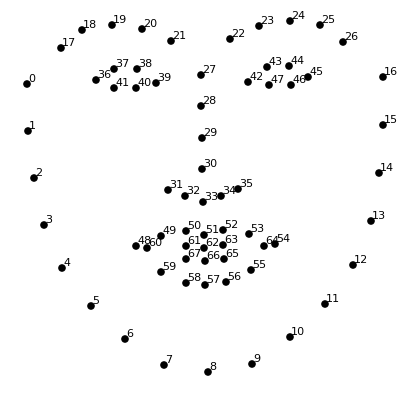

In [19]:
from IPython.display import Image
Image("indicies.png")

In [32]:
#Funções MAR
import math 
# http://vision.fe.uni-lj.si/cvww2016/proceedings/papers/05.pdf
def compute_mouth_open_2pontos(shape, boca): #função para pegar os pontos especificos da boca e calcular a distancia euclidiana e o ratio
    aux_contador = 0
    if boca:
        aux_contador = 48
    mouth_left = [49-aux_contador,59-aux_contador] #posição 49 referente a canto esquerdo superior e 59 canto esquerdo inferior...
    mouth_right = [53-aux_contador,55-aux_contador]
    mouth_hor = [60-aux_contador,64-aux_contador] #pontos extremos horizontalmente (60 esquerda, 64 direita)
    distance_mouth_left  = math.sqrt((shape.part(mouth_left[0]).x  - shape.part(mouth_left[1]).x)**2 +  
                                     (shape.part(mouth_left[0]).y  - shape.part(mouth_left[1]).y)**2 )
    distance_mouth_right = math.sqrt((shape.part(mouth_right[0]).x - shape.part(mouth_right[1]).x)**2 +  
                                     (shape.part(mouth_right[0]).y - shape.part(mouth_left[1]).y)**2 )
    distance_mouth_hor   = math.sqrt((shape.part(mouth_hor[0]).x   - shape.part(mouth_hor[1]).x)**2 +  
                                     (shape.part(mouth_hor[0]).y   - shape.part(mouth_hor[1]).y)**2 )
    
    aspect_ratio = (distance_mouth_left + distance_mouth_right) / (2.0 * distance_mouth_hor)
    
    return aspect_ratio

def compute_mouth_open_3pontos(shape, boca): #função para pegar os pontos especificos da boca e calcular a distancia euclidiana e o ratio
    aux_contador = 0
    if boca:
        aux_contador = 48
    mouth_left = [49-aux_contador,59-aux_contador] #posição 49 referente a canto esquerdo superior e 59 canto esquerdo inferior...
    mouth_midle = [51-aux_contador,57-aux_contador]
    mouth_right = [53-aux_contador,55-aux_contador]
    mouth_hor = [60-aux_contador,64-aux_contador] #pontos extremos horizontalmente (60 esquerda, 64 direita)
    distance_mouth_left  = math.sqrt((shape.part(mouth_left[0]).x  - shape.part(mouth_left[1]).x)**2 +  
                                     (shape.part(mouth_left[0]).y  - shape.part(mouth_left[1]).y)**2 )
    distance_mouth_midle = math.sqrt((shape.part(mouth_midle[0]).x - shape.part(mouth_midle[1]).x)**2 +  
                                     (shape.part(mouth_midle[0]).y - shape.part(mouth_midle[1]).y)**2 )
    distance_mouth_right = math.sqrt((shape.part(mouth_right[0]).x - shape.part(mouth_right[1]).x)**2 +  
                                     (shape.part(mouth_right[0]).y - shape.part(mouth_left[1]).y)**2 )
    distance_mouth_hor   = math.sqrt((shape.part(mouth_hor[0]).x   - shape.part(mouth_hor[1]).x)**2 +  
                                     (shape.part(mouth_hor[0]).y   - shape.part(mouth_hor[1]).y)**2 )
    
    aspect_ratio = (distance_mouth_left + distance_mouth_midle + distance_mouth_right) / (3.0 * distance_mouth_hor)
    
    return aspect_ratio

def compute_mouth_open_3pontos_emX(shape, boca): #função para pegar os pontos especificos da boca e calcular a distancia euclidiana e o ratio
    aux_contador = 0
    if boca:
        aux_contador = 48
    mouth_left = [49-aux_contador,55-aux_contador] #posição 49 referente a canto esquerdo superior e 55 canto direito inferior...
    mouth_midle = [51-aux_contador,57-aux_contador]
    mouth_right = [53-aux_contador,59-aux_contador] #posição 53 referente a canto direito superior e 59 canto esquerdo inferior...
    mouth_hor = [60-aux_contador,64-aux_contador] #pontos extremos horizontalmente (60 esquerda, 64 direita)
    distance_mouth_left  = math.sqrt((shape.part(mouth_left[0]).x  - shape.part(mouth_left[1]).x)**2 +  
                                     (shape.part(mouth_left[0]).y  - shape.part(mouth_left[1]).y)**2 )
    distance_mouth_midle = math.sqrt((shape.part(mouth_midle[0]).x - shape.part(mouth_midle[1]).x)**2 +  
                                     (shape.part(mouth_midle[0]).y - shape.part(mouth_midle[1]).y)**2 )
    distance_mouth_right = math.sqrt((shape.part(mouth_right[0]).x - shape.part(mouth_right[1]).x)**2 +  
                                     (shape.part(mouth_right[0]).y - shape.part(mouth_left[1]).y)**2 )
    distance_mouth_hor   = math.sqrt((shape.part(mouth_hor[0]).x   - shape.part(mouth_hor[1]).x)**2 +  
                                     (shape.part(mouth_hor[0]).y   - shape.part(mouth_hor[1]).y)**2 )
    
    aspect_ratio = (distance_mouth_left + distance_mouth_midle + distance_mouth_right) / (3.0 * distance_mouth_hor)
    
    return aspect_ratio

def compute_mouth_open_2pontos_emX(shape, boca): #função para pegar os pontos especificos da boca e calcular a distancia euclidiana e o ratio
    aux_contador = 0
    if boca:
        aux_contador = 48
    mouth_left = [49-aux_contador,55-aux_contador] #posição 49 referente a canto esquerdo superior e 55 canto direito inferior...
    mouth_right = [53-aux_contador,59-aux_contador] #posição 53 referente a canto direito superior e 59 canto esquerdo inferior...
    mouth_hor = [60-aux_contador,64-aux_contador] #pontos extremos horizontalmente (60 esquerda, 64 direita)
    distance_mouth_left  = math.sqrt((shape.part(mouth_left[0]).x  - shape.part(mouth_left[1]).x)**2 +  
                                     (shape.part(mouth_left[0]).y  - shape.part(mouth_left[1]).y)**2 )
    distance_mouth_right = math.sqrt((shape.part(mouth_right[0]).x - shape.part(mouth_right[1]).x)**2 +  
                                     (shape.part(mouth_right[0]).y - shape.part(mouth_left[1]).y)**2 )
    distance_mouth_hor   = math.sqrt((shape.part(mouth_hor[0]).x   - shape.part(mouth_hor[1]).x)**2 +  
                                     (shape.part(mouth_hor[0]).y   - shape.part(mouth_hor[1]).y)**2 )
    
    aspect_ratio = (distance_mouth_left + distance_mouth_right) / (2.0 * distance_mouth_hor)
    
    return aspect_ratio

In [34]:
def testa_frames(frame, landmark, boca): #Função já utilizando o novo modelo como preditior.
    aux_contador = 0
    if boca:
        aux_contador = 48
    frame = imutils.resize(frame, width=640)
    h,w = frame.shape[:2]

    frame = cv2.flip(frame,180) 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(gray)

    detector = dlib.get_frontal_face_detector() #Face detector
    predictor = dlib.shape_predictor(landmark) #Landmark identificador da biblioteca dlib

    detections = detector(clahe_image, 1) #Detectar mais de uma face.
    for k,d in enumerate(detections): #Para cada face 
        shape = predictor(clahe_image, d) #Get coordinates
        distance_month = compute_mouth_open_3pontos(shape, boca) #Função para calcular o MAR (mouth aspect ratio) como artigo [1]   
        print(distance_month)
        for i in range(48-aux_contador,68-aux_contador): #Dlib positions (48 até 67 são pontos referentes a boca)
            cv2.circle(frame, (shape.part(i).x, shape.part(i).y), 2, (0,255,0), thickness=-1) #desenta 1 circulo em cada ponto da dlib para a boca.
            #cv2.putText(frame, str(i), (shape.part(i).x, shape.part(i).y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0),2) #printa as posições na face

    if distance_month >= 0.35: #se o ratio maior que .35 então esta com a boca aberta. (Valor baseado em testes)
        cv2.putText(frame, "Falando!", (30,60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255),2)

    plt.imshow(frame[:,:,::-1]) # usando matplotlib inline para jupyter.
    plt.show()


0.3680262252923908


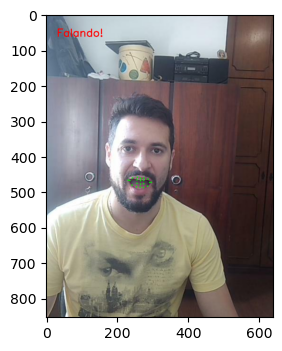

0.18039113243282412


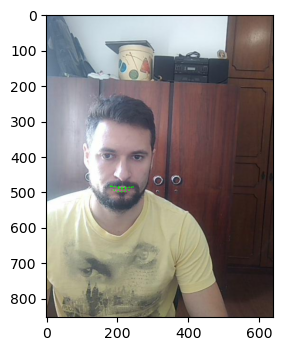

0.5112058953285585


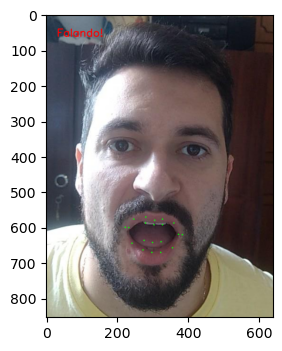

In [47]:
#Testes utilizando webcam
frame = cv2.imread("teste/bocaAberta.JPG")
testa_frames(frame, 'shape_predictor_68_face_landmarks.dat', False)
frame = cv2.imread("teste/bocaFechada.JPG")
testa_frames(frame, 'shape_predictor_68_face_landmarks.dat', False)
frame = cv2.imread("teste/IMG_20201222_113019.JPG") 
testa_frames(frame, 'shape_predictor_68_face_landmarks.dat', False)

0.5709704520410863


0.1670348710263402


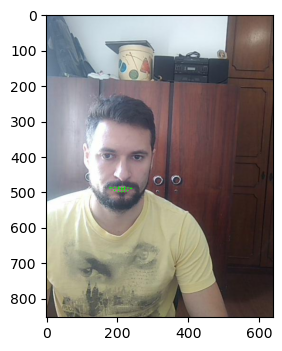

0.8232455132472354


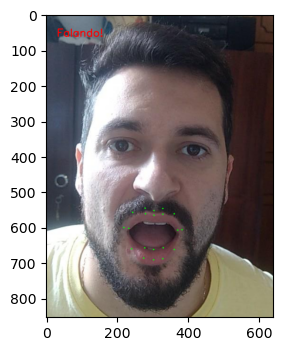

In [48]:
#Testes utilizando webcam
frame = cv2.imread("teste/bocaAberta.JPG")
testa_frames(frame, 'shapemouth2.dat', True)
frame = cv2.imread("teste/bocaFechada.JPG")
testa_frames(frame, 'shapemouth2.dat', True)
frame = cv2.imread("teste/IMG_20201222_113019.JPG") 
testa_frames(frame, 'shapemouth2.dat', True)

Baseado nos testes simples feitos pela webcam, alterando o shape predictor para o modelo que foi otimizado utilizando apenas os pontos da boca, foi possivel obter resultados que descrevem melhor os frames. ("shapemouth2.dat")

In [35]:
video_capture = cv2.VideoCapture("people-talking.mp4") #Video de entrada
detector = dlib.get_frontal_face_detector() #Face detector do DLIB
predictor = dlib.shape_predictor("shapemouth2.dat") #modelo utilizando somente os pontos da boca
frame_width = 640
frame_height = 360
out = cv2.VideoWriter('outpy2.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width,frame_height))

while True:
    ret, frame = video_capture.read()
    if not ret: break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detections = detector(gray, 1) #Detectar mais de uma face.
    for k,d in enumerate(detections): #Para cada face 
        shape = predictor(gray, d)  #Get coordinates
        distance_month = compute_mouth_open_3pontos(shape, True) #Função para calcular o MAR (mouth aspect ratio) como artigo [1]
        cv2.putText(frame, str(distance_month), (30,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255),2)
        for i in range(48-48,68-48): #Dlib positions (48 até 67 são pontos referentes a boca)
            cv2.circle(frame, (shape.part(i).x, shape.part(i).y), 2, (0,255,0), thickness=-1) #desenta 1 circulo em cada ponto da dlib para a boca.
        if distance_month >= 0.35: #se o ratio maior que .35 então esta com a boca aberta. (Valor baseado em testes)
            cv2.putText(frame, "Falando!", (30,60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255),2)
    out.write(frame)
    cv2.imshow("frame", frame) #Display the frame
    if cv2.waitKey(1) & 0xFF == ord('q'): #Exit program when the user presses 'q'
        break

video_capture.release()
out.release()
cv2.destroyAllWindows()


In [49]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='saida/BocaAberta.png'></td><td><img src='saida/BocaFechada.png'></td></tr></table>"))

In [50]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('saida/out-usandoshapeDefault68.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""<video width=640 controls>     
<source src="%s" type="video/mp4">
</video>""" % data_url)

In [51]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('saida/out-usandoshapesoboca.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""<video width=640 controls>     
<source src="%s" type="video/mp4">
</video>""" % data_url)

obs: Derivações de modelos usando os pontos de face do IBug são para uso não comercial...